<a href="https://colab.research.google.com/github/ratulKabir/Classification-of-the-102-Category-Flowers-Dataset/blob/master/Accuracy_per_class_cross_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importing Libraries

In [0]:
% tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from tensorflow.keras import models, layers

from google.colab import drive
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold

## 2. Loading and Preparing Data

In [0]:
##Mounting The Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir("drive/My Drive/Colab Notebooks/flowers")

In [0]:
# Loading pickled data

pickle_in = open("resized_train_data.pickle","rb")
train_data = pickle.load(pickle_in)

pickle_in = open("resized_val_data.pickle","rb")
validation_data = pickle.load(pickle_in)

pickle_in = open("resized_test_data.pickle","rb")
test_data = pickle.load(pickle_in)

No blueish pics anymore, thanks to Voeller!!!

11


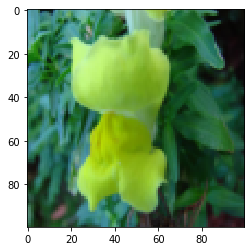

In [0]:
print(train_data[304][1])
plt.imshow(train_data[304][0])

In [0]:
train_img = []
train_lbl = []
for elem in range(len(train_data)):
  train_img.append(train_data[elem][0])
  train_lbl.append(train_data[elem][1])
  if train_lbl[elem] == 102:
    train_lbl[elem] = 0

validation_img = []
validation_lbl = []
for elem in range(len(validation_data)):
  validation_img.append(validation_data[elem][0])
  validation_lbl.append(validation_data[elem][1])
  if validation_lbl[elem] == 102:
    validation_lbl[elem] = 0

test_img = []
test_lbl = []
for elem in range(len(test_data)):
  test_img.append(test_data[elem][0])
  test_lbl.append(test_data[elem][1])
  if test_lbl[elem] == 102:
    test_lbl[elem] = 0

In [0]:
train_img = np.asarray(train_img)
train_lbl = np.asarray(train_lbl)

test_img = np.asarray(test_img)
test_lbl = np.asarray(test_lbl)

validation_img = np.asarray(validation_img)
validation_lbl = np.asarray(validation_lbl)

data = tf.data.Dataset.from_tensor_slices(
    (train_img.reshape([-1, 100, 100, 3]).astype(np.float32) / 255, train_lbl.astype(np.int32)))


data = data.shuffle(buffer_size=60000).batch(64).repeat()

test_data = tf.data.Dataset.from_tensor_slices(
    (test_img.reshape([-1, 100, 100, 3]).astype(np.float32) / 255, test_lbl.astype(np.int32))).batch(64)

validation_data = tf.data.Dataset.from_tensor_slices(
    (validation_img.reshape([-1, 100, 100, 3]).astype(np.float32) / 255, validation_lbl.astype(np.int32))).batch(64)

# for cifar10
train_lbl = train_lbl.reshape((-1,)) 
test_lbl = test_lbl.reshape((-1,))

## 3. Defining Model

#### 3.1. Simple small CNN

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,100,3)))
model.add(layers.MaxPooling2D(4,4))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(4,4))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(102, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 5, 5, 64)          256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)             

In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10, restore_best_weights=True)

history = model.fit(data, callbacks=[callback], validation_data = validation_data, steps_per_epoch=200, epochs=50)
#history = model.fit(data, validation_data = validation_data, steps_per_epoch=200, epochs=20)

Train for 200 steps, validate for 23 steps
Epoch 1/50
200/200 [==============================] - 5s 23ms/step - loss: 3.1473 - accuracy: 0.2649 - val_loss: 4.6298 - val_accuracy: 0.0140
Epoch 2/50
200/200 [==============================] - 4s 19ms/step - loss: 1.6498 - accuracy: 0.5636 - val_loss: 5.5186 - val_accuracy: 0.0161
Epoch 3/50
200/200 [==============================] - 4s 18ms/step - loss: 0.9475 - accuracy: 0.7412 - val_loss: 8.8214 - val_accuracy: 0.0364
Epoch 4/50
200/200 [==============================] - 4s 18ms/step - loss: 0.5181 - accuracy: 0.8688 - val_loss: 3.2100 - val_accuracy: 0.3408
Epoch 5/50
200/200 [==============================] - 4s 18ms/step - loss: 0.2712 - accuracy: 0.9440 - val_loss: 2.9942 - val_accuracy: 0.4248
Epoch 6/50
200/200 [==============================] - 3s 17ms/step - loss: 0.1397 - accuracy: 0.9791 - val_loss: 2.5678 - val_accuracy: 0.4934
Epoch 7/50
200/200 [==============================] - 4s 18ms/step - loss: 0.0594 - accuracy: 0.996

#### 3.1.1. Plotting train and validation accuracy/loss

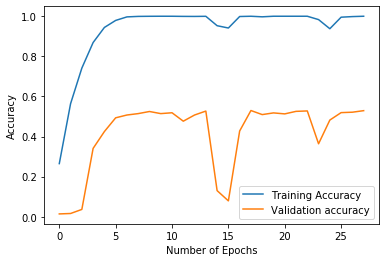

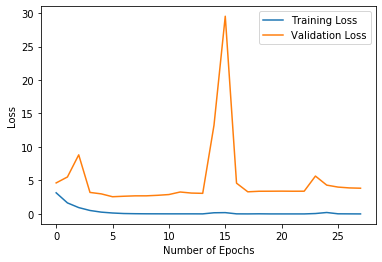

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation accuracy'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(('Training Loss', 'Validation Loss'))
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.show()

In [0]:
test = model.evaluate(test_data)
#print(test)

23/23 [==============================] - 0s 11ms/step - loss: 3.8727 - accuracy: 0.4732


#### 3.1.2. Confusion Matrix
- confusion matrix for multiple classes:
https://www.youtube.com/watch?v=FAr2GmWNbT0
- The matrix columns represent the prediction labels and the rows represent the real labels. The confusion matrix is always a 2-D array of shape [n, n], where n is the number of valid labels for a given classification task.
https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix

In [0]:
# Counting the number of images per class

counts_per_class = []
for class_num in range(102):
  count = 0
  for label in test_lbl:
    if label == class_num:
      count += 1
  counts_per_class.append(count)

# counts_per_class

In [0]:
pred_test = tf.argmax(model(test_img.reshape([-1, 100, 100, 3]).astype(np.float32) / 255), axis=1).numpy()
conf_mat = tf.math.confusion_matrix(test_lbl, pred_test)
tf.print(conf_mat, summarize=5)

[[5 0 0 0 0 ... 0 0 0 0 0]
 [0 1 0 0 0 ... 0 0 0 0 0]
 [0 0 9 0 0 ... 0 0 0 0 0]
 [0 0 0 0 0 ... 0 0 0 0 0]
 [0 0 0 1 0 ... 0 0 0 0 0]
 ...
 [0 0 0 0 0 ... 5 0 0 0 0]
 [0 0 0 0 0 ... 0 6 0 0 0]
 [0 0 2 0 0 ... 0 0 2 0 0]
 [0 0 0 0 0 ... 0 0 1 4 0]
 [0 0 0 0 0 ... 0 0 0 0 0]]


In [0]:
# conf_pecentage = tf.Variable(tf.zeros(102,102))
conf_mat_percent = conf_mat.numpy()
for i in range(102):
  for j in range(102):
    conf_mat_percent[i,j] = conf_mat[i,j] / counts_per_class[i] * 100 

In [0]:
tf.print(conf_mat_percent, summarize=5)

array([[55,  0,  0, ...,  0,  0,  0],
       [ 0, 16,  0, ...,  0,  0,  0],
       [ 0,  0, 90, ...,  0,  0,  0],
       ...,
       [ 0,  0, 20, ..., 20,  0,  0],
       [ 0,  0,  0, ..., 12, 50,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32)


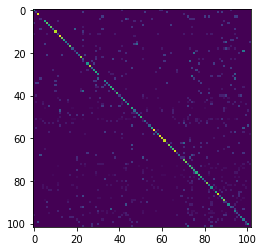

In [0]:
plt.imshow(conf_mat_percent, interpolation='nearest')

#### 3.1.3. Precision per class and average precision

In [0]:
precisions = []
for i in range(len(conf_mat)):
  if tf.reduce_sum(conf_mat[:, i]) == 0:
    #precisions.append(conf_mat[i,i] / tf.reduce_sum(conf_mat[:, i]))
    precisions.append(tf.cast(conf_mat[i,i], dtype=tf.dtypes.float64))
  else:
    precisions.append(conf_mat[i,i] / tf.reduce_sum(conf_mat[:, i]))

('The precision is ',(tf.reduce_sum(precisions) / len(precisions)).numpy())

('The precision is ', 0.45703403429367434)

Text(0.5, 1.0, 'Precision of test data with simple CNN')

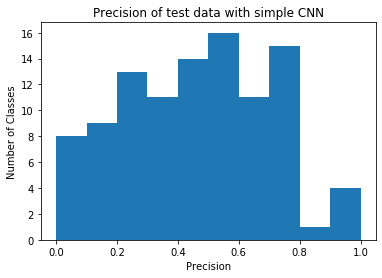

In [0]:
plt.hist(precisions)
plt.xlabel('Precision')
plt.ylabel('Number of Classes')
plt.title('Precision of test data with simple CNN')

Text(0.5, 1.0, 'Precision per class')

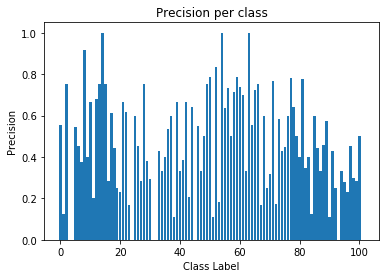

In [0]:
plt.bar(np.arange(len(precisions)), precisions, align='center', alpha=1)
#plt.hist(precisions)
plt.xlabel('Class Label')
plt.ylabel('Precision')
plt.title('Precision per class')

#### 3.1.4. Visualizing 0 and 1 precision classes

In [0]:
zero_index = []
one_index = []
for _, prec in enumerate(precisions):
  if prec == 0:
    zero_index.append(_)
  elif prec == 1:
    one_index.append(_)
#zero_index

Showing images with 0 precision

3


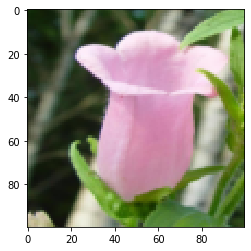

4


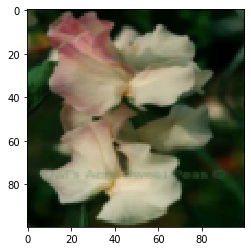

6


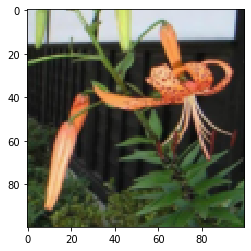

31


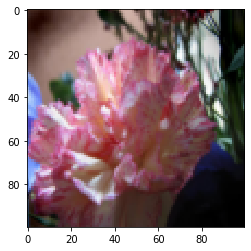

32


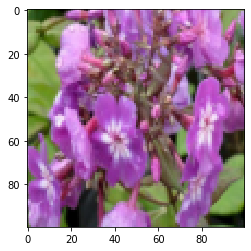

62


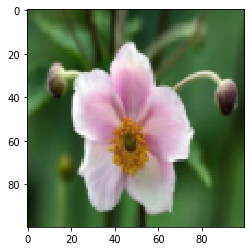

69


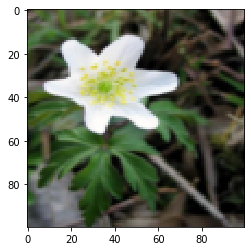

In [0]:
for zero in zero_index:
  print(zero)
  for i in range (len(test_lbl)):
    if test_lbl[i] == zero:
      plt.imshow(test_img[i])
      plt.show()
      break
      #print(test_lbl[i])
      #break

Showing images with precision 1

14


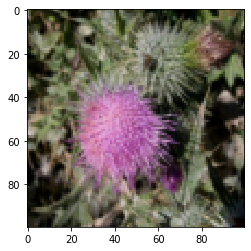

16


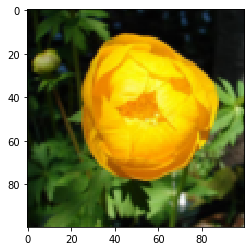

71


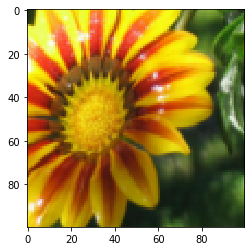

100


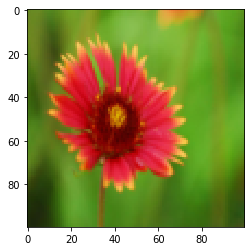

In [0]:
for one in one_index:
  print(one)
  for i in range(len(test_lbl)):
    #print(test_lbl[i])
    if test_lbl[i] == one:
      plt.imshow(test_img[i])
      plt.show()
      #print(i)
      break

#### 3.1.4 Accuracy per class

Class specific accuracy

In [0]:
########### average Accuracy
# accuracy = 0
# for test, pred in zip(test_lbl, pred_test):
#   if test == pred:
#     accuracy += 1

# print(accuracy/len(test_lbl))

########### Checking the confuison matrix
# class_zero = 0
# for test in test_lbl:
#   if test == 99:
#     class_zero += 1

# print((tf.reduce_sum(conf_mat[99]).numpy()), class_zero)

########## Accuracy per class
acc_per_class = []
for i in range(len(conf_mat)):
  acc_per_class.append(conf_mat[i,i]/tf.reduce_sum(conf_mat[i]))
  #conf_mat[i,i]/tf.reduce_sum(conf_mat[i])

#acc_per_class

In [0]:
tf.reduce_sum(acc_per_class)/len(acc_per_class)

<tf.Tensor: shape=(), dtype=float64, numpy=0.44443556347767577>

Text(0.5, 1.0, 'Accuracy of test data per class')

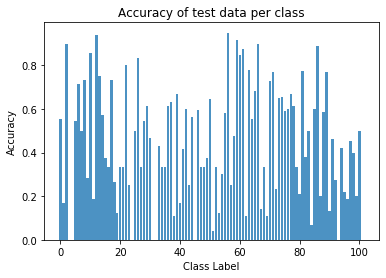

In [0]:
plt.bar(np.arange(len(acc_per_class)), np.array(acc_per_class), align='center', alpha=0.8)
plt.xlabel('Class Label')
plt.ylabel('Accuracy')
plt.title('Accuracy of test data per class')

In [0]:
zero_index, one_index

([3, 4, 6, 31, 32, 62, 69], [14, 16, 71, 100])

In [0]:
count = 0
counts_zero = []
counts_one = []

for zero in zero_index:
  for tr_lbl in train_lbl:
    if tr_lbl == zero:
      count += 1
  counts_zero.append(count)
  count = 0

for one in one_index:
  for tr_lbl in train_lbl:
    if tr_lbl == one:
      count += 1
  counts_one.append(count)
  count = 0

print(counts_zero)
print(counts_one)

[23, 33, 26, 30, 26, 32, 31]
[28, 24, 46, 28]


In [0]:
pred_val = tf.argmax(model(validation_img.reshape([-1, 100, 100, 3]).astype(np.float32) / 255), axis=1).numpy()
conf_mat_val = tf.math.confusion_matrix(validation_lbl, pred_val)

In [0]:
acc_per_class_val = []
for i in range(len(conf_mat_val)):
  acc_per_class_val.append(conf_mat_val[i,i]/tf.reduce_sum(conf_mat_val[i]))
  #conf_mat[i,i]/tf.reduce_sum(conf_mat[i])

tf.reduce_sum(acc_per_class_val)/len(acc_per_class_val)

<tf.Tensor: shape=(), dtype=float64, numpy=0.46021665553843527>

In [0]:
plt.bar(np.arange(len(acc_per_class_val)), np.array(acc_per_class_val), align='center', alpha=0.8)
plt.xlabel('Class Label')
plt.ylabel('Accuracy')
plt.title('Accuracy of validation data per class')

In [0]:
plt.hist(acc_per_class_val)

#### Cross-Validation

https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_2_kfold.ipynb

In [0]:
train_img.shape, validation_img.shape

((4815, 100, 100, 3), (1429, 100, 100, 3))

In [0]:
train_val_img = np.concatenate((train_img, validation_img))
train_val_lbl = np.concatenate((train_lbl, validation_lbl))
train_val_img.shape, train_val_lbl.shape

((6244, 100, 100, 3), (6244,))

In [0]:
kf = StratifiedKFold(10, shuffle=True, random_state=4)

In [0]:
test_acc_k_fold = []
for train, val in kf.split(train_val_img, train_val_lbl):
  #print(train.shape, val.shape)
  train_img_k_fold = train_val_img[train]
  train_lbl_k_fold = train_val_lbl[train]
  validation_img_k_fold = train_val_img[val]
  validation_lbl_k_fold = train_val_lbl[val]
  #print(x_train.shape, train.shape, validation_img_k_fold.shape)
  #break
  data = tf.data.Dataset.from_tensor_slices(
    (train_img_k_fold.reshape([-1, 100, 100, 3]).astype(np.float32) / 255, train_lbl_k_fold.astype(np.int32)))
  
  data = data.shuffle(buffer_size=60000).batch(64).repeat()
  
  validation_data = tf.data.Dataset.from_tensor_slices(
    (validation_img_k_fold.reshape([-1, 100, 100, 3]).astype(np.float32) / 255, validation_lbl_k_fold.astype(np.int32))).batch(10000)
  
  # Model
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,100,3)))
  model.add(layers.MaxPooling2D(4,4))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(4,4))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(102, activation='softmax'))

  model.summary()

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  #callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5, restore_best_weights=True)

  # history = model.fit(data, callbacks=[callback], validation_data = validation_data, steps_per_epoch=200, epochs=10)
  history = model.fit(data, validation_data = validation_data, steps_per_epoch=200, epochs=10)

  test = model.evaluate(test_data)
  pred_test = tf.argmax(model(test_img.reshape([-1, 100, 100, 3]).astype(np.float32) / 255), axis=1).numpy()
  conf_mat = tf.math.confusion_matrix(test_lbl, pred_test)

  acc_per_class = []
  for i in range(len(conf_mat)):
    acc_per_class.append(conf_mat[i,i]/tf.reduce_sum(conf_mat[i]))

  test_acc = tf.reduce_sum(acc_per_class)/len(acc_per_class)
  test_acc_k_fold.append(test_acc)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 5, 5, 64)          256       
_________________________________________________________________
flatten_11 (Flatten)         (None, 1600)            

In [0]:
test_acc_k_fold

[<tf.Tensor: shape=(), dtype=float64, numpy=0.4832963151473384>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.3110013161211242>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.4783613540791431>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.48559173634172803>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.4993781701746844>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.5043115111060569>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.4910446278442457>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.4820278435165531>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.5042733814629837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.49462069000996306>]

(array([1., 0., 0., 0., 0., 0., 0., 0., 3., 6.]),
 array([0.31100132, 0.33033234, 0.34966336, 0.36899437, 0.38832539,
        0.40765641, 0.42698743, 0.44631845, 0.46564947, 0.48498049,
        0.50431151]),
 <a list of 10 Patch objects>)

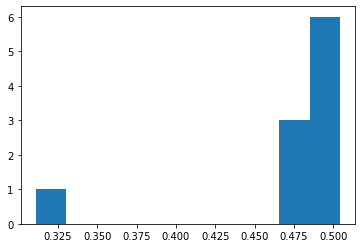

In [0]:
plt.hist(test_acc_k_fold)

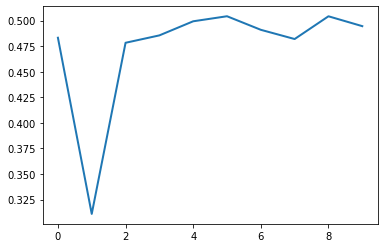

In [0]:
plt.plot(test_acc_k_fold, linewidth=2.0)

Standard Deviation

In [0]:
np.std(test_acc_k_fold)

0.05483079879953749

In [0]:
np.mean(test_acc_k_fold)

0.473390694580382

In [0]:
min(test_acc_k_fold)

<tf.Tensor: shape=(), dtype=float64, numpy=0.3110013161211242>

In [0]:
max(test_acc_k_fold)

<tf.Tensor: shape=(), dtype=float64, numpy=0.5043115111060569>